# 2. 거울아 거울아, 나는 멍멍이 상이니, 아니면 냥이 상이니? [프로젝트]

## 2-1. 프로젝트: 새로운 데이터셋으로 나만의 이미지 분류기 만들어보기

In [1]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [2]:
import tensorflow_datasets as tfds
print(tfds.__version__)
help(tfds)

C:\Users\uilov\anaconda3\envs\tfgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4.9.4
Help on package tensorflow_datasets:

NAME
    tensorflow_datasets - `tensorflow_datasets` (`tfds`) defines a collection of datasets ready-to-use with TensorFlow.

DESCRIPTION
    Each dataset is defined as a `tfds.core.DatasetBuilder`, which encapsulates
    the logic to download the dataset and construct an input pipeline, as well as
    contains the dataset documentation (version, splits, number of examples, etc.).
    
    The main library entrypoints are:
    
    * `tfds.builder`: fetch a `tfds.core.DatasetBuilder` by name
    * `tfds.load`: convenience method to construct a builder, download the data, and
      create an input pipeline, returning a `tf.data.Dataset`.
    
    Documentation:
    
    * These API docs
    * [Available datasets](https://www.tensorflow.org/datasets/catalog/overview)
    * [Colab tutorial](https://colab.research.google.com/github/tensorflow/datasets/blob/master/docs/overview.ipynb)
    * [Add a dataset](https://www.tensorflow.org/datasets/add_d

In [3]:
import os
data_path = os.path.join(os.getcwd(), 'data', 'tf_flowers')

if not os.path.exists(data_path):
    os.makedirs(data_path)

In [4]:
import os

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    name='tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir= data_path,
    download=False,
    with_info=True,
    as_supervised=True,
)

### 1. 데이터 확인 및 전처리

In [5]:
# 데이터 확인

print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [86]:
# 그래프 세팅

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

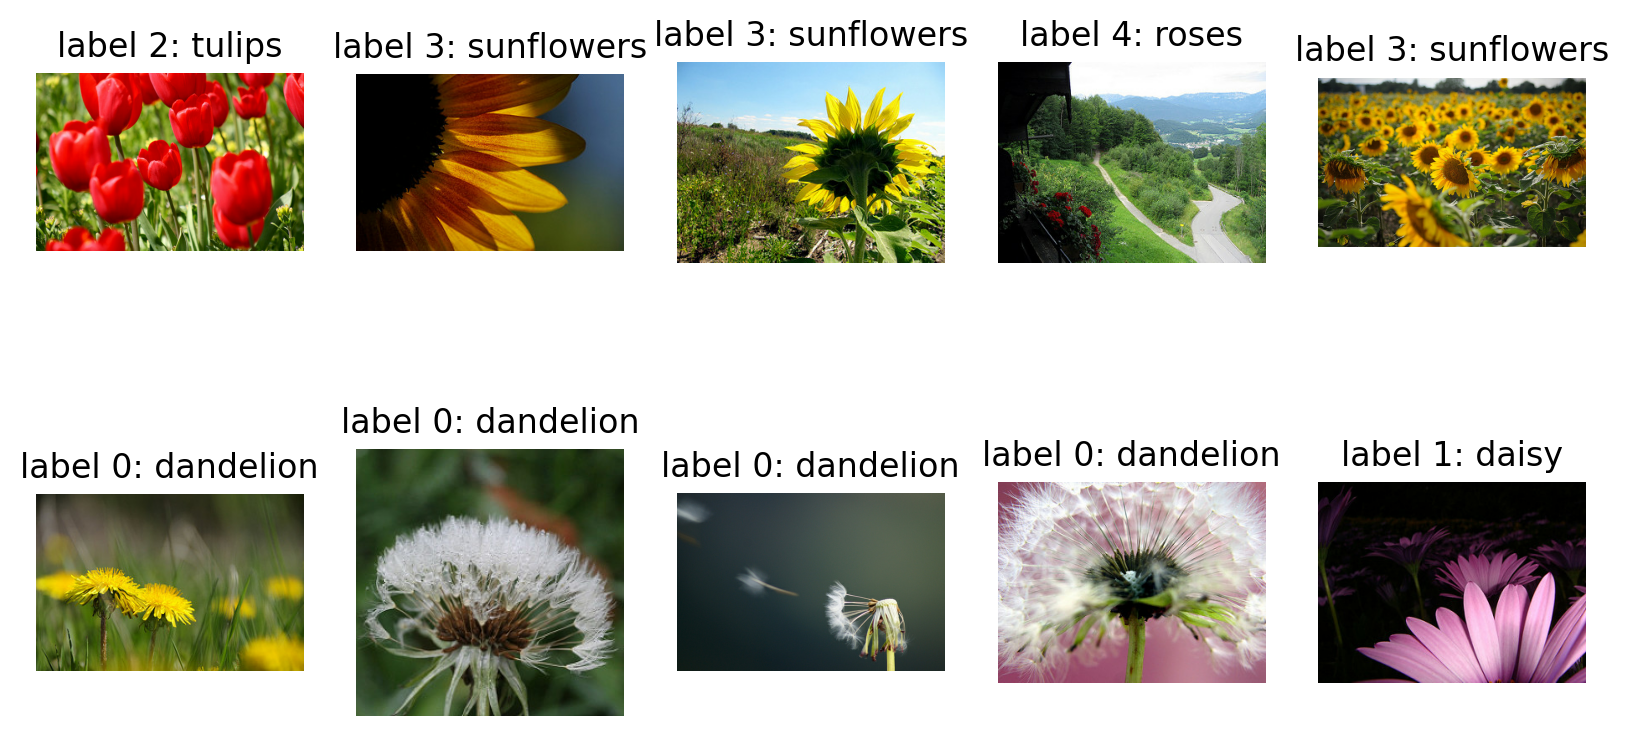

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

In [8]:
# 클래스 개수 확인

get_label_name

<bound method ClassLabel.int2str of ClassLabel(shape=(), dtype=int64, num_classes=5)>

In [14]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label, num_classes=5):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/255) # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, num_classes)
    return image, label

In [15]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))>
<MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(5,), dtype=tf.float32, name=None))>


In [16]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = validation.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for image_batch, label_batch in train_batches.take(1):
    break

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32, 5]))

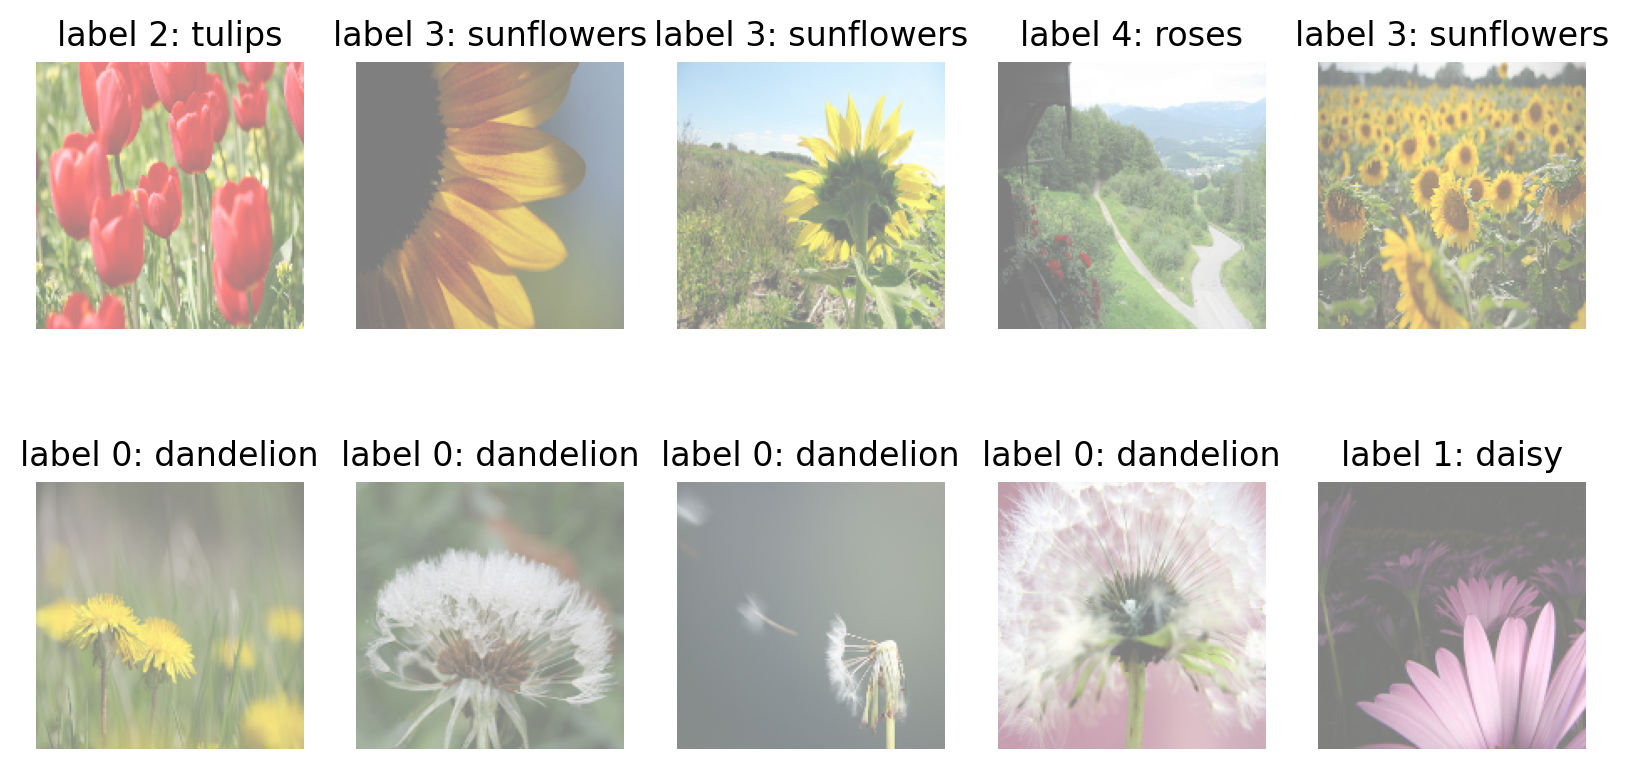

In [17]:
import numpy as np

plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {np.argmax(label)}: {get_label_name(np.argmax(label))}')
    plt.axis('off')

### 2. 신경망 구성하기
- Transfer learning
- 모델 선택하기

In [18]:
dir(tf.keras.applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'Re

In [19]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# VGG19으로 선정 / fully-connected layer는 제외
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                             include_top=False,
                                             weights='imagenet')

In [20]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [21]:
with tf.device('/GPU:0'):
    from tensorflow.keras.models import Sequential

    model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(5, activation='softmax')
    ])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2

In [23]:
with tf.device('/GPU:0'):
    learning = 0.001
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall')]
    )

### 3. 에폭 사전 준비

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

### 4. 학습시키기

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(train_batches,
                        epochs=100,
                        validation_data=validation_batches,
                        callbacks=[early_stopping])

Epoch 1/100
92/92 [==============================] - 89s 698ms/step - loss: 1.4915 - accuracy: 0.3420 - precision: 0.5242 - recall: 0.1291 - val_loss: 24.1050 - val_accuracy: 0.3188 - val_precision: 0.3169 - val_recall: 0.3161
Epoch 2/100
92/92 [==============================] - 51s 545ms/step - loss: 1.4231 - accuracy: 0.4005 - precision: 0.5773 - recall: 0.1805 - val_loss: 1.5674 - val_accuracy: 0.3569 - val_precision: 0.4226 - val_recall: 0.3052
Epoch 3/100
92/92 [==============================] - 52s 560ms/step - loss: 1.2790 - accuracy: 0.4721 - precision: 0.6558 - recall: 0.2459 - val_loss: 31.9866 - val_accuracy: 0.4768 - val_precision: 0.6126 - val_recall: 0.3706
Epoch 4/100
92/92 [==============================] - 53s 570ms/step - loss: 1.2506 - accuracy: 0.4775 - precision: 0.6305 - recall: 0.2749 - val_loss: 2.2452 - val_accuracy: 0.5150 - val_precision: 0.5654 - val_recall: 0.4714
Epoch 5/100
92/92 [==============================] - 53s 574ms/step - loss: 1.1933 - accuracy:

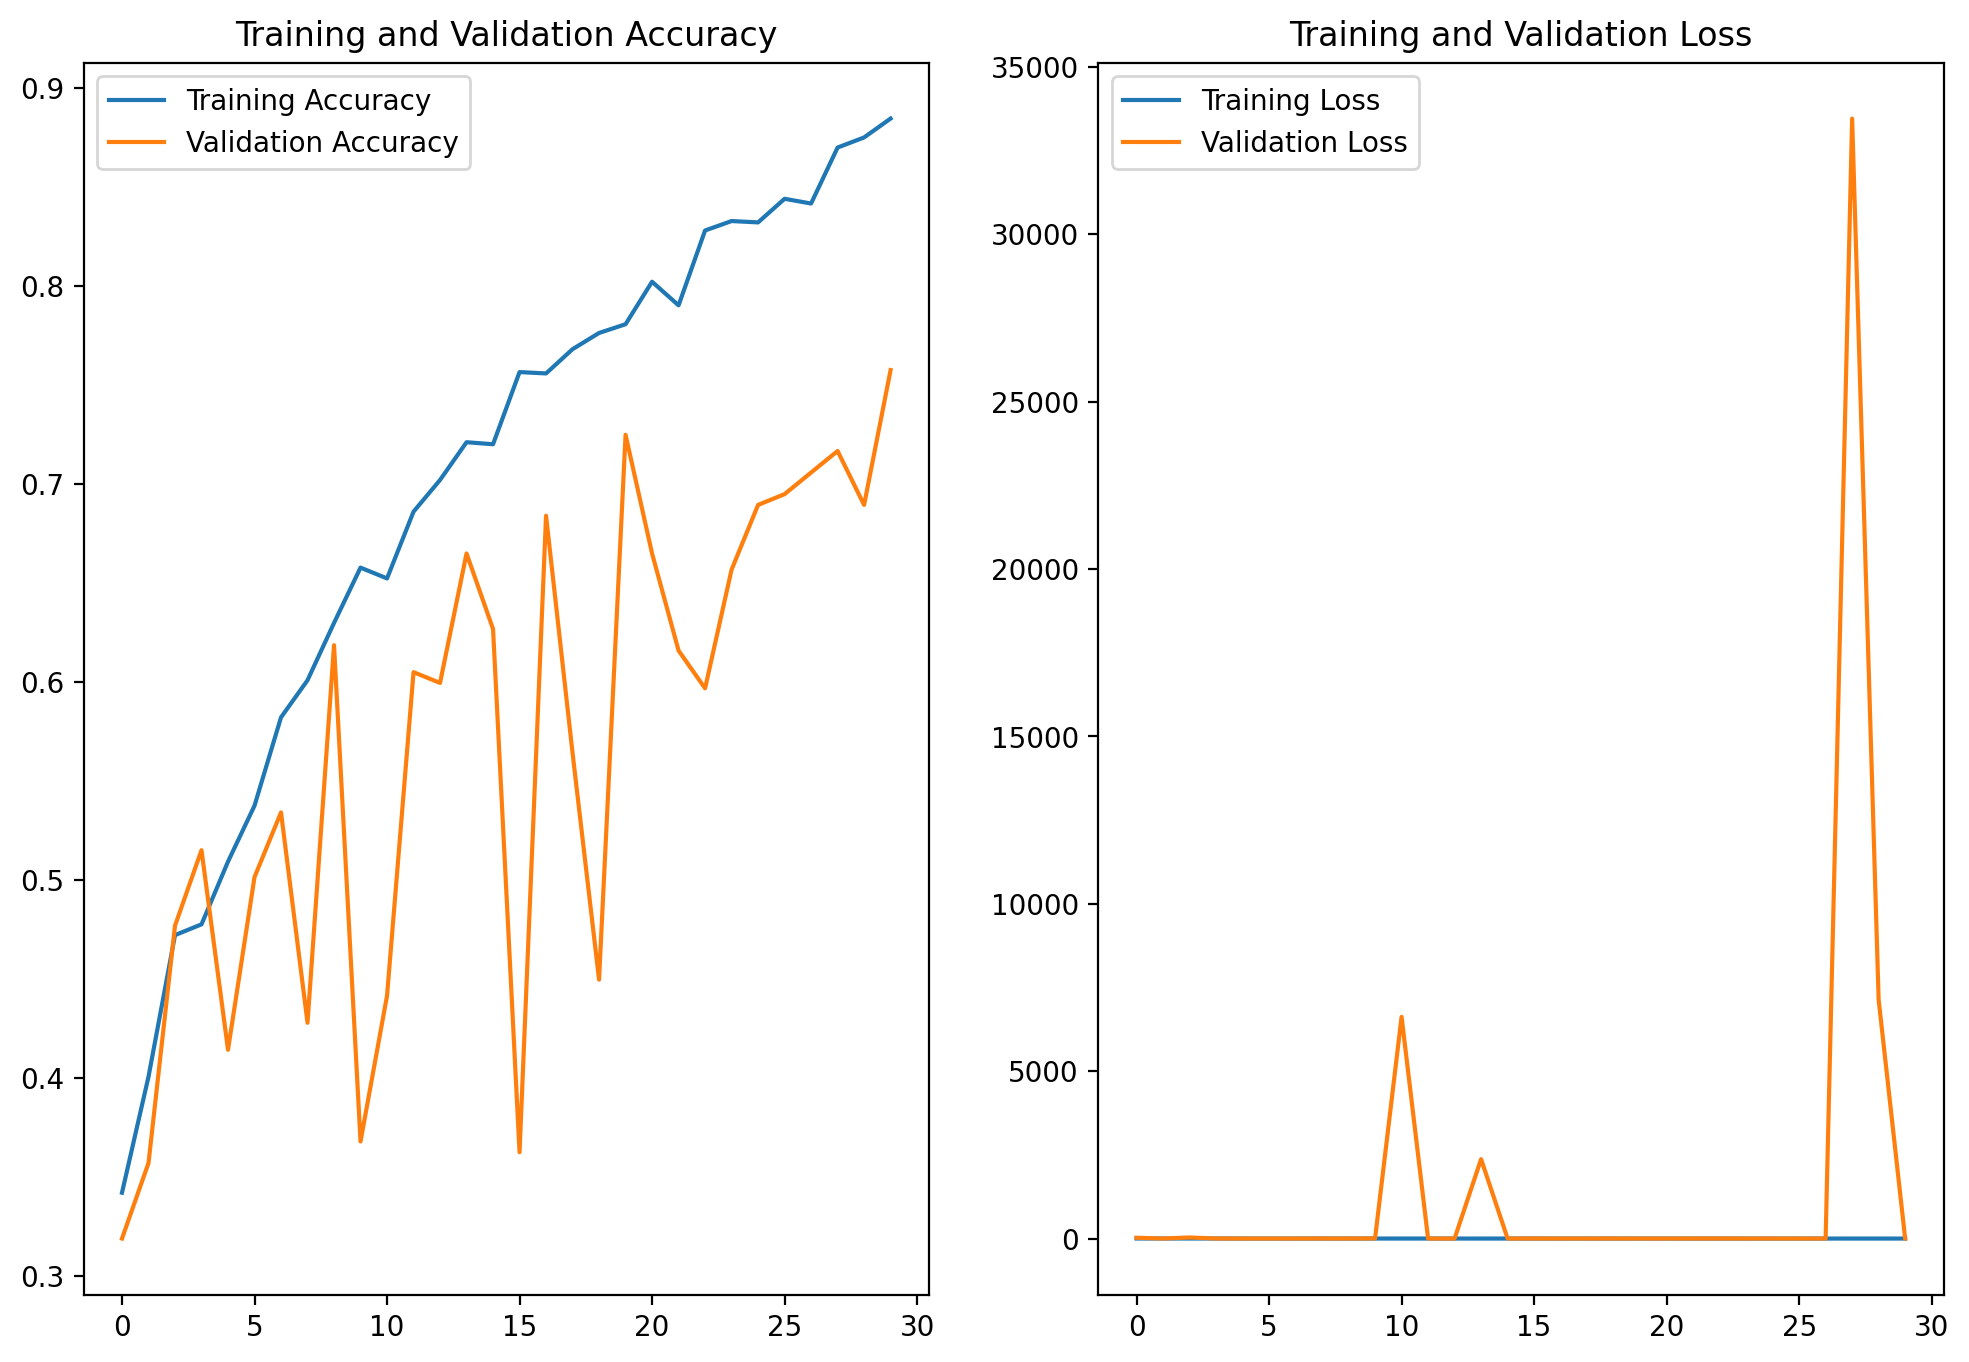

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

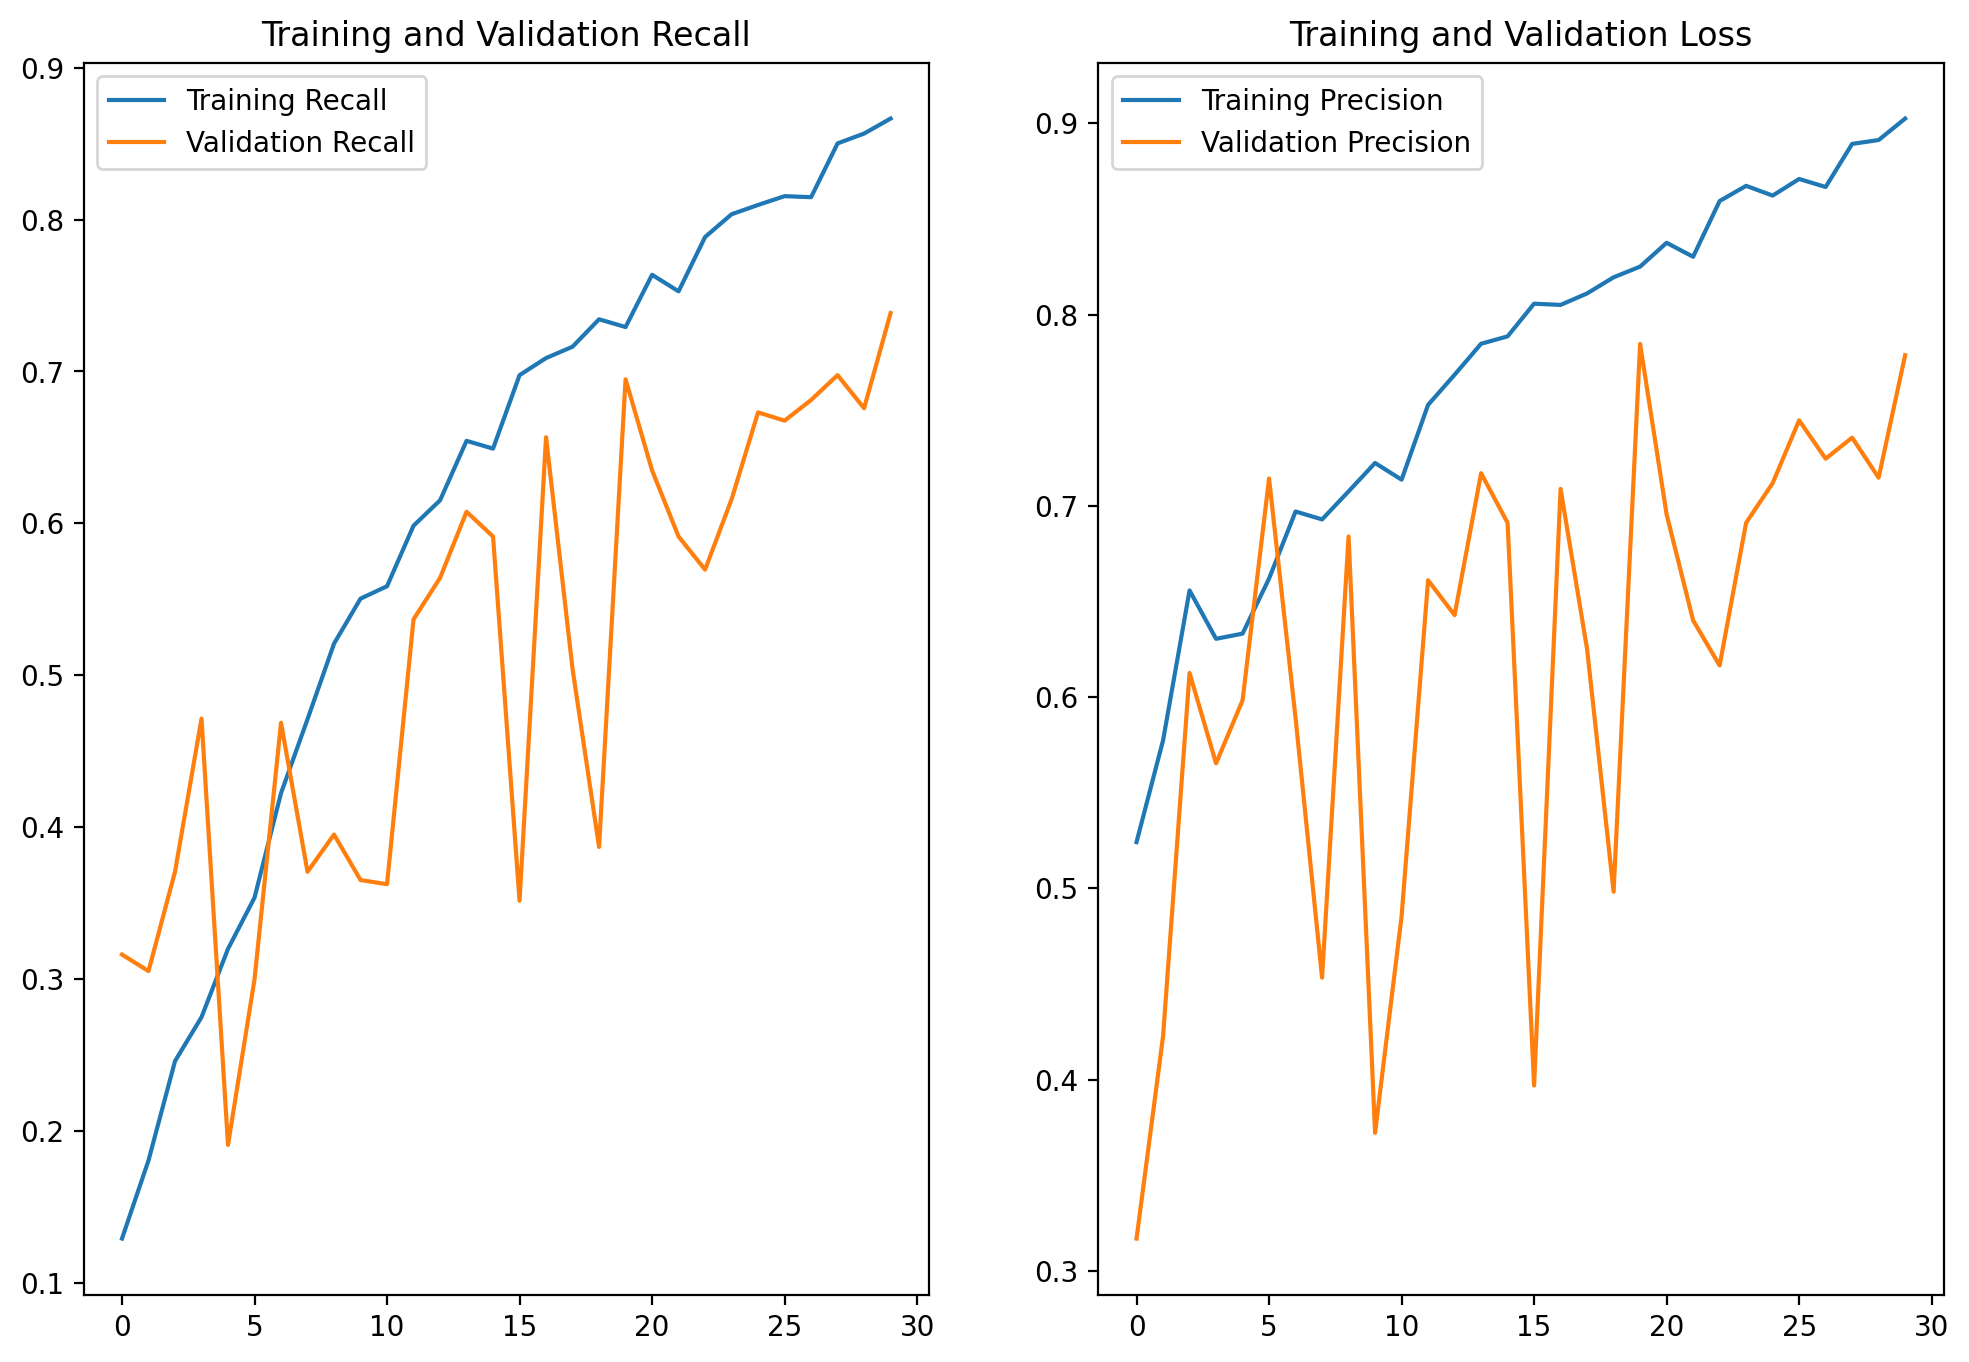

In [30]:
rec = history.history['recall']
val_rec = history.history['val_recall']

pre=history.history['precision']
val_pre=history.history['val_precision']

epochs_range = range(30)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend()
plt.title('Training and Validation Recall')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, pre, label='Training Precision')
plt.plot(epochs_range, val_pre, label='Validation Precision')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [28]:
model.evaluate(test_batches)

12/12 [==============================] - 2s 121ms/step - loss: 0.6907 - accuracy: 0.7575 - precision: 0.8129 - recall: 0.7221


[0.6907209157943726,
 0.7574931979179382,
 0.8128834366798401,
 0.7220708727836609]

In [49]:
test_batches

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [33]:
np.argmax(next(iter(test_batches))[-1], axis=1)

array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 1, 4, 4, 3, 0, 4], dtype=int64)

In [63]:
target = []
for image, label in test_batches:
    target.append(np.argmax(label,axis=1))

In [64]:
target

[array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
        2, 0, 1, 3, 1, 4, 4, 3, 0, 4], dtype=int64),
 array([4, 4, 2, 1, 4, 0, 1, 3, 4, 3, 3, 4, 1, 1, 0, 0, 4, 2, 4, 0, 4, 1,
        1, 2, 4, 2, 1, 2, 4, 3, 3, 1], dtype=int64),
 array([0, 1, 3, 2, 3, 3, 2, 2, 4, 2, 0, 3, 1, 2, 4, 0, 4, 4, 1, 4, 0, 3,
        2, 2, 4, 1, 2, 0, 1, 1, 3, 3], dtype=int64),
 array([3, 3, 4, 4, 3, 2, 4, 4, 2, 0, 3, 4, 2, 1, 2, 4, 2, 1, 4, 0, 4, 0,
        1, 2, 2, 1, 4, 2, 2, 2, 3, 0], dtype=int64),
 array([3, 3, 0, 4, 4, 1, 3, 3, 2, 1, 2, 4, 3, 1, 3, 2, 1, 4, 3, 0, 3, 2,
        2, 4, 4, 0, 0, 3, 2, 3, 4, 4], dtype=int64),
 array([2, 4, 4, 1, 1, 3, 4, 2, 3, 1, 0, 4, 4, 4, 4, 2, 4, 1, 0, 3, 2, 4,
        3, 2, 4, 4, 1, 3, 3, 2, 1, 0], dtype=int64),
 array([0, 2, 2, 2, 4, 1, 0, 0, 1, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 4, 3, 3,
        3, 4, 1, 0, 2, 3, 2, 3, 3, 4], dtype=int64),
 array([4, 2, 0, 0, 1, 2, 0, 2, 4, 3, 3, 1, 1, 3, 2, 1, 2, 3, 3, 1, 3, 1,
        4, 4, 0, 1, 2, 0, 4, 0, 3, 2]

In [69]:
target = tf.concat(target, axis=0)
target

<tf.Tensor: shape=(367,), dtype=int64, numpy=
array([4, 0, 0, 2, 0, 0, 2, 1, 3, 0, 0, 0, 3, 4, 0, 3, 2, 0, 2, 4, 2, 0,
       2, 0, 1, 3, 1, 4, 4, 3, 0, 4, 4, 4, 2, 1, 4, 0, 1, 3, 4, 3, 3, 4,
       1, 1, 0, 0, 4, 2, 4, 0, 4, 1, 1, 2, 4, 2, 1, 2, 4, 3, 3, 1, 0, 1,
       3, 2, 3, 3, 2, 2, 4, 2, 0, 3, 1, 2, 4, 0, 4, 4, 1, 4, 0, 3, 2, 2,
       4, 1, 2, 0, 1, 1, 3, 3, 3, 3, 4, 4, 3, 2, 4, 4, 2, 0, 3, 4, 2, 1,
       2, 4, 2, 1, 4, 0, 4, 0, 1, 2, 2, 1, 4, 2, 2, 2, 3, 0, 3, 3, 0, 4,
       4, 1, 3, 3, 2, 1, 2, 4, 3, 1, 3, 2, 1, 4, 3, 0, 3, 2, 2, 4, 4, 0,
       0, 3, 2, 3, 4, 4, 2, 4, 4, 1, 1, 3, 4, 2, 3, 1, 0, 4, 4, 4, 4, 2,
       4, 1, 0, 3, 2, 4, 3, 2, 4, 4, 1, 3, 3, 2, 1, 0, 0, 2, 2, 2, 4, 1,
       0, 0, 1, 0, 2, 2, 0, 2, 3, 1, 0, 2, 2, 4, 3, 3, 3, 4, 1, 0, 2, 3,
       2, 3, 3, 4, 4, 2, 0, 0, 1, 2, 0, 2, 4, 3, 3, 1, 1, 3, 2, 1, 2, 3,
       3, 1, 3, 1, 4, 4, 0, 1, 2, 0, 4, 0, 3, 2, 0, 0, 3, 1, 1, 4, 0, 4,
       3, 2, 1, 1, 0, 4, 0, 3, 0, 0, 1, 4, 2, 1, 0, 2, 4, 2, 2, 3, 0, 3,
     

'dandelion'

12/12 [==============================] - 2s 142ms/step
              precision    recall  f1-score   support

   dandelion       0.90      0.61      0.73        70
       daisy       0.85      0.77      0.81        61
      tulips       0.72      0.78      0.75        85
  sunflowers       0.76      0.91      0.83        76
       roses       0.65      0.71      0.68        75

    accuracy                           0.76       367
   macro avg       0.78      0.76      0.76       367
weighted avg       0.77      0.76      0.76       367

--------------------------------------------------


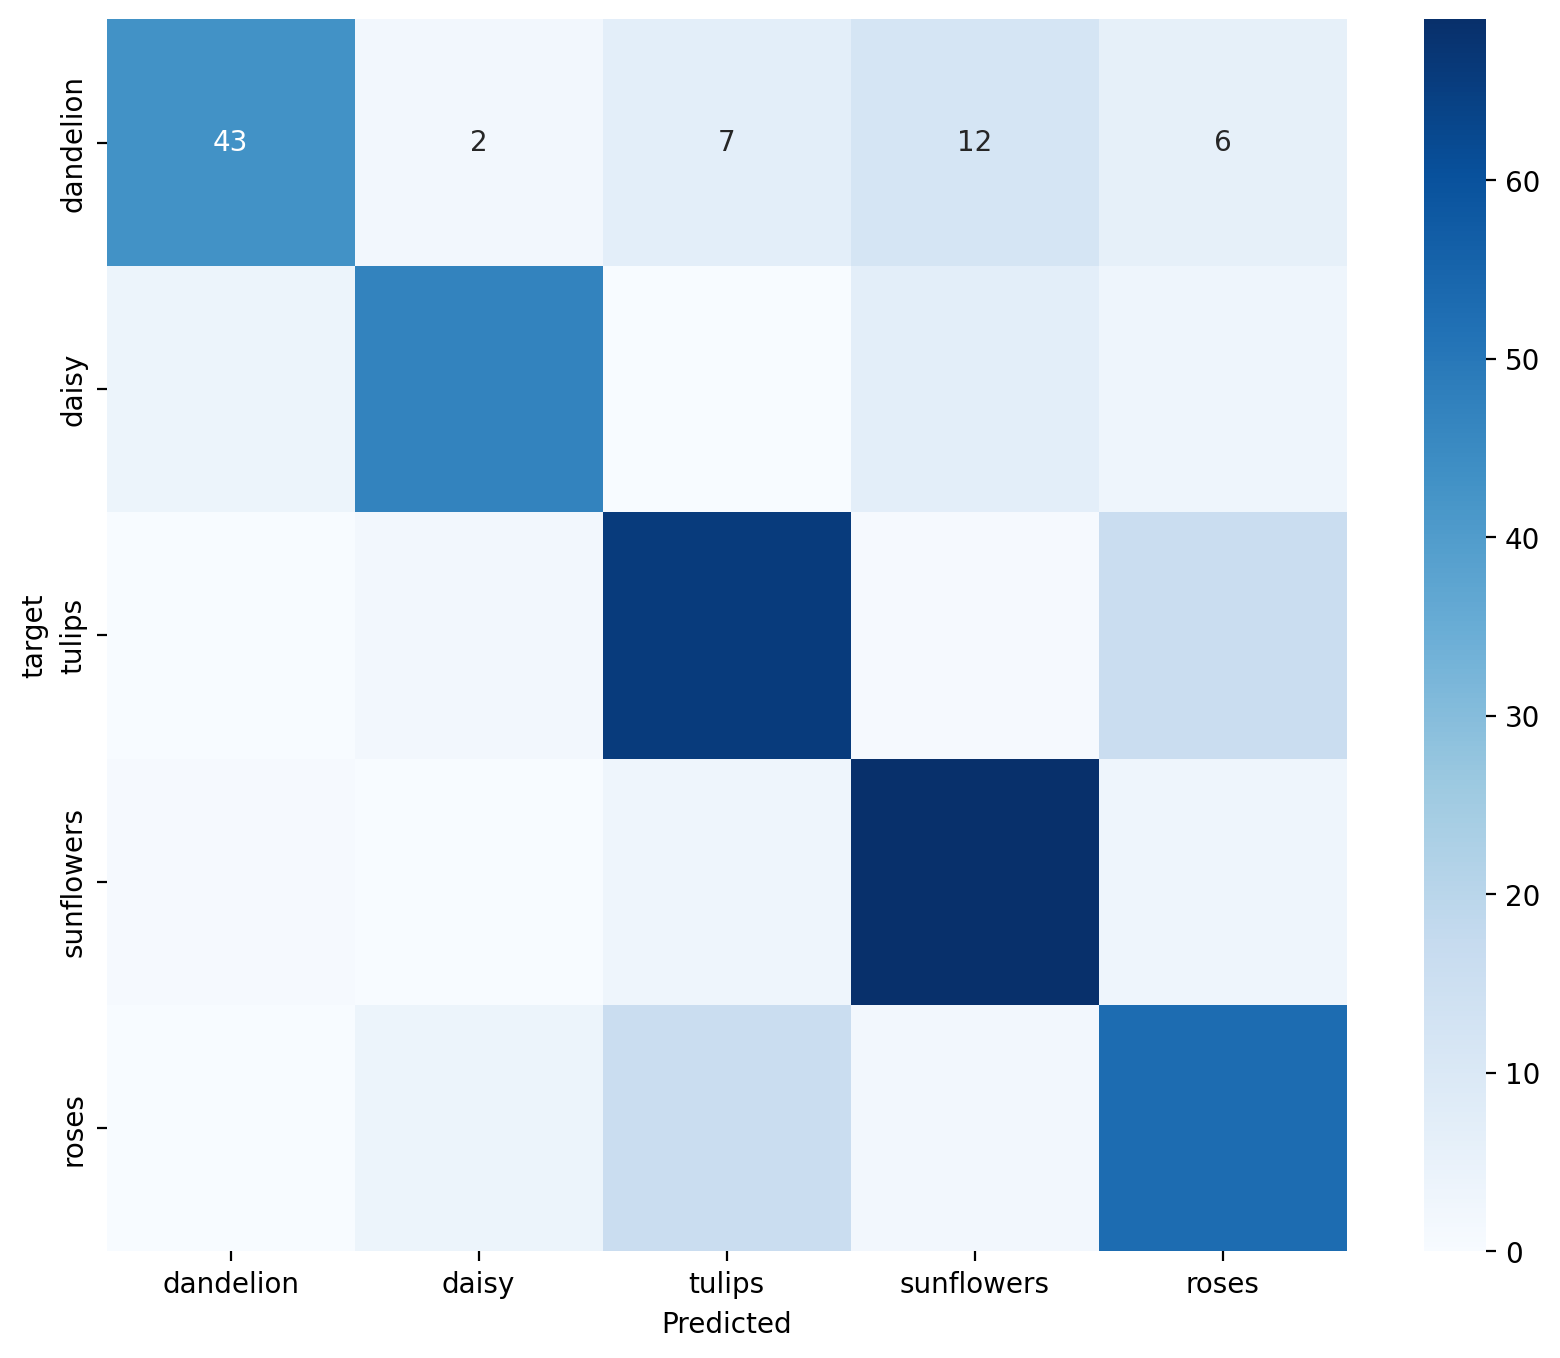

--------------------------------------------------


,dandelion,daisy,tulips,sunflowers,roses
dandelion,43,2,7,12,6
daisy,4,47,0,7,3
tulips,0,2,66,1,16
sunflowers,1,0,3,69,3
roses,0,4,16,2,53


In [91]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

pred = np.argmax(model.predict(test_batches), axis=1)
report = classification_report(target, pred, target_names=[get_label_name(i) for i in range(5)])
conf_mat = confusion_matrix(target, pred)
conf_mat_df = pd.DataFrame(conf_mat, index=[get_label_name(i) for i in range(5)], columns=[get_label_name(i) for i in range(5)])

print(report)
print("-"*50)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_df, annot=True, fmt=".0f", cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('target')
plt.show()
print("-"*50)
display(conf_mat_df)

In [85]:
conf_mat

array([[43,  2,  7, 12,  6],
       [ 4, 47,  0,  7,  3],
       [ 0,  2, 66,  1, 16],
       [ 1,  0,  3, 69,  3],
       [ 0,  4, 16,  2, 53]], dtype=int64)

# 회고
## Keep
텐서플로우 내장 VGG19을 이용하여 transfer_learning을 진행하였다. 과적합을 방지하기 위해 배치정규화와 드롭아웃을 진행하였고 동시에 학습률을 조정하였다. 대신 에폭수를 늘려나가되, early_stop콜백함수를 통해 에폭수를 높이 되, validation loss가 떨어지는 방향으로 진행하였다.

## Problem
1. 초기엔 출력값 5개의 노드와 맞지 않다고 나왔었다.
2. 노드 aiffel에서 결국 터져서 다시 로컬로 와서 진행하였으나, 고해상도 이미지는 메모리부족 문제가 발생하였다.
3. 처음엔 이 전 개와 고양이 분류문제처럼 scale을 할 때 122.5를 나누고 1을 빼는 식으로 진행하였으나, 정확도가 오르지 않는 것 같았다.

## Try
1. 클래스를 원 핫인코딩으로 수정하고 원 핫인코딩엔 sparce_categorical_crossentropy는 사용하기 적절하지 않아 수정하였다.
2. 이미지 사이즈를 기존에 하려 했던 224가 아닌 160으로 줄여서 진행하였다.
3. MinMaxScale로 수정하였다.(255 나누기) 정확도가 이전보다는 증가하는 듯 했다.